# 1. 이미지 전처리

### 라이브러리 인스톨

In [ ]:
#!pip install umap-learn hdbscan transformers

In [1]:
import torch

print("CUDA 사용 가능 여부:", torch.cuda.is_available())

CUDA 사용 가능 여부: True


### 라이브러리 임포트

In [2]:
import os
import cv2
import random
import numpy as np
import skimage
import umap
import hdbscan
import pandas as pd
import torch

from glob import glob
from collections import Counter
from tqdm.auto import tqdm
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize

/home/team1/anaconda3/envs/mj/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BATCH_SIZE = 8
SEED = 42

## CLIP 모델과 UMAP을 통한 이미지 클러스터링 하기

### Clip 모델을 통해 임베딩 하기

In [4]:
# https://huggingface.co/geolocal/StreetCLIP
# StreetCLIP is a robust foundation model for open-domain image geolocalization and other geographic and climate-related tasks.

clip_model = CLIPModel.from_pretrained("geolocal/StreetCLIP")
clip_model.to('cuda:1')
clip_processor = CLIPProcessor.from_pretrained("geolocal/StreetCLIP")

In [5]:
image_paths = sorted(glob('/home/team1/restore_image/train_gt/*.png'))

In [6]:
image_features = []
for i in tqdm(range(0,len(image_paths), BATCH_SIZE)):
    image_paths_batch = image_paths[i:i+BATCH_SIZE]
    images = [Image.open(image_path) for image_path in image_paths_batch]
    pixel_values = clip_processor.image_processor(images=images, return_tensors='pt')['pixel_values'].to('cuda:1')
    with torch.no_grad():
        image_features_row = clip_model.get_image_features(pixel_values).cpu().numpy()
    image_features.append(image_features_row)

100%|██████████| 3701/3701 [20:46<00:00,  2.97it/s]


In [7]:
train_embeddings = np.vstack(image_features)

In [8]:
train_embeddings = normalize(train_embeddings, norm="l2")

In [9]:
#np.save('/home/team1/mj/preproc/train_embeddings', train_embeddings)
train_embeddings = np.load('/home/team1/mj/preproc/train_embeddings.npy')

### UMAP을 통해 이미지 임베딩을 클러스터링하기

In [10]:
clusterable_embedding = umap.UMAP(
    n_neighbors=5,
    min_dist=0.0,
    n_components=2,
    random_state=SEED,
).fit_transform(train_embeddings)

/home/team1/anaconda3/envs/mj/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


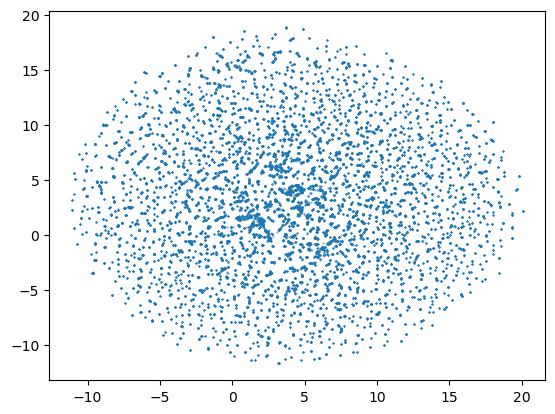

In [11]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1)

In [12]:
labels = hdbscan.HDBSCAN(
    min_cluster_size=5,
).fit_predict(clusterable_embedding)

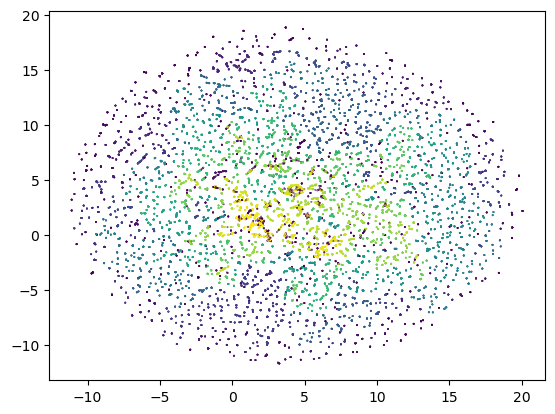

In [13]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=labels, s=0.1)

In [14]:
len(set(labels)), sum(labels==-1)

(2438, 2010)

In [15]:
counter = Counter([label for label in labels if label!=-1])

In [16]:
min(counter.values()), np.median(list(counter.values())), max(counter.values())

(5, 10.0, 65)

## 클러스터 별 이미지 확인 및 저장하기

label is 0


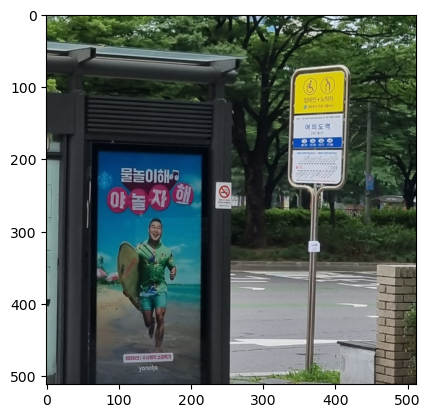

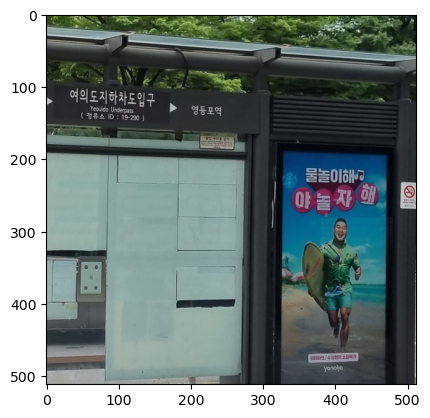

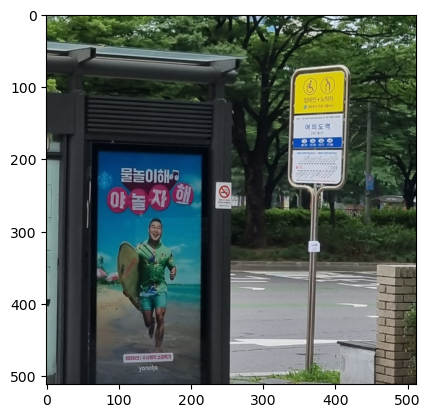

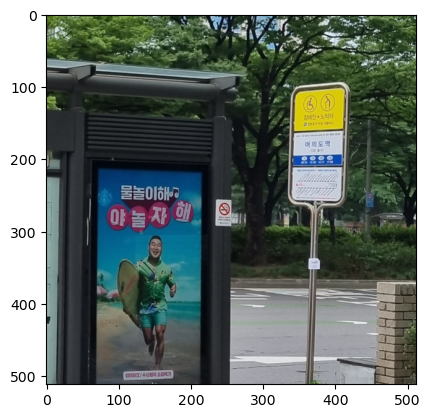

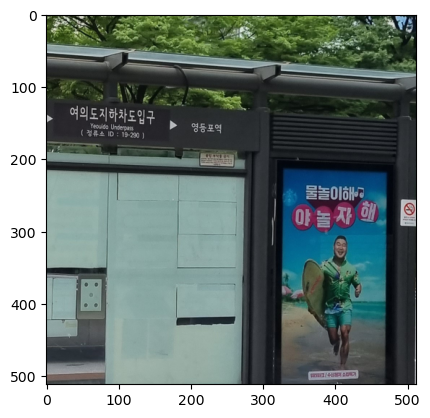

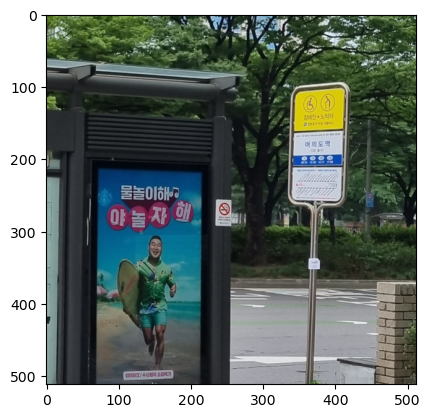

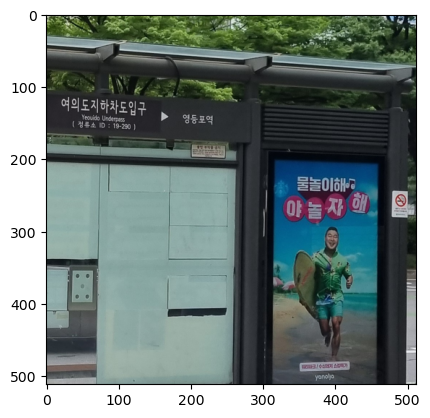

label is 1


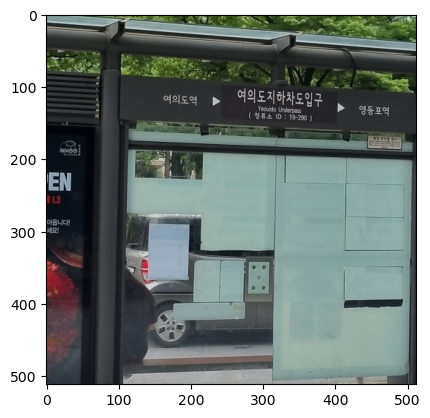

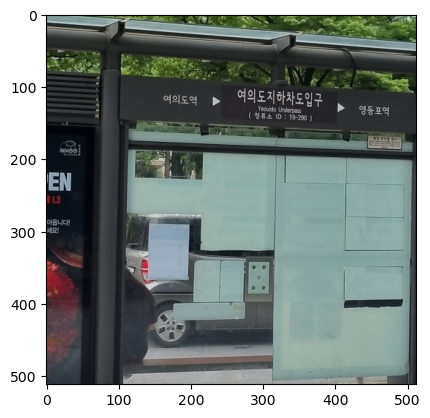

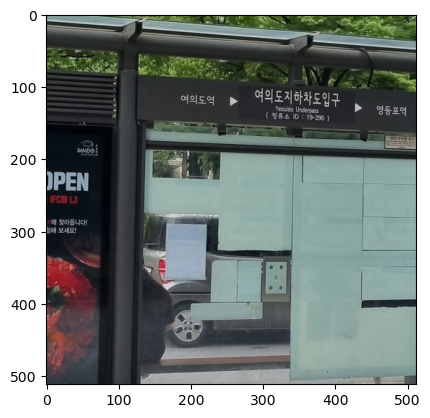

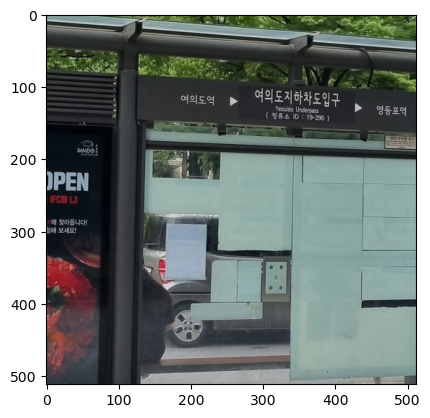

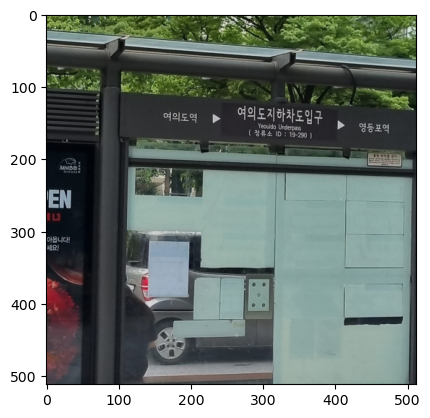

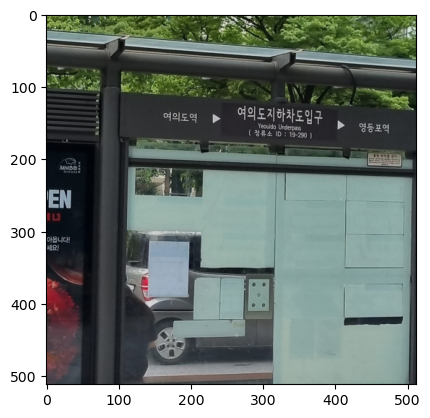

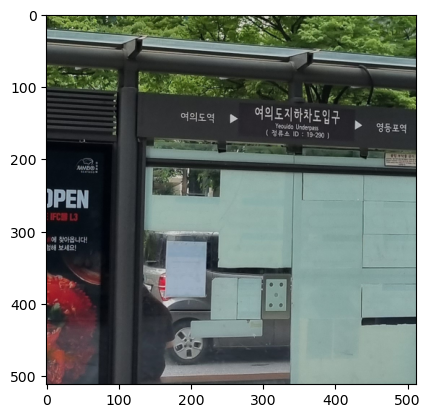

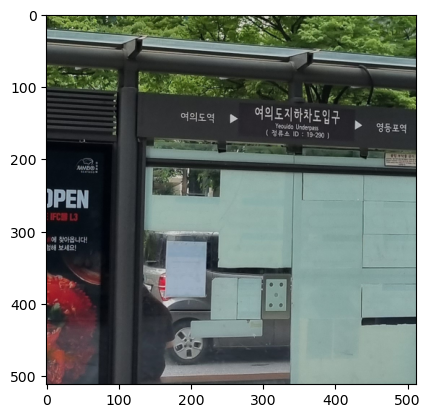

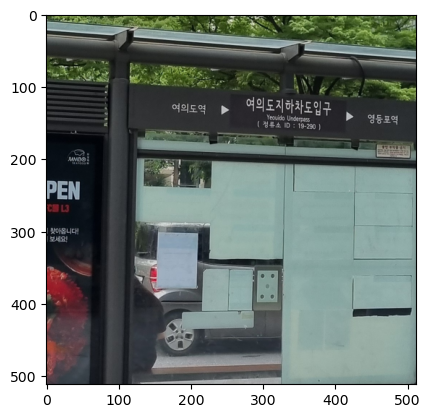

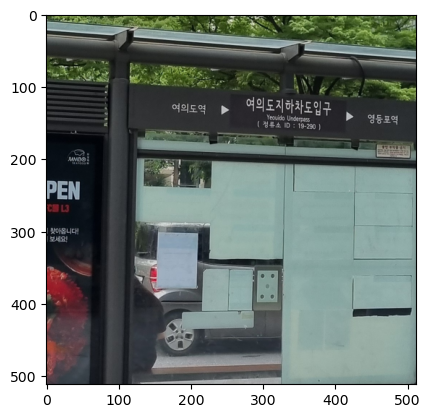

In [17]:
print('label is 0')
for image_path in np.array(image_paths)[labels==0]:
    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()
print('label is 1')
for image_path in np.array(image_paths)[labels==1]:
    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()

In [18]:
train_df = pd.DataFrame(columns=['image','label'])

In [19]:
train_df['image'] = [os.path.basename(image_path) for image_path in image_paths]
train_df['label'] = labels

In [20]:
train_df.to_csv('/home/team1/mj/preproc/train_preproc.csv', index=False)

In [21]:
test_image_paths = sorted(glob('/home/team1/restore_image/test_input/*.png'))

In [22]:
test_df = pd.DataFrame(columns=['image'])

In [23]:
test_df['image'] = [os.path.basename(image_path) for image_path in test_image_paths]

In [24]:
test_df.to_csv('/home/team1/mj/preproc/test_preproc.csv', index=False)

# 2. 모델 학습 코드

### 라이브러리 인스톨

In [25]:
#!pip install polygenerator lightning segmentation-models-pytorch

### 라이브러리 임포트 및 필요한 함수 작성

In [26]:
import os
import math
import random
import zipfile
import cv2
import numpy as np
import skimage
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
import segmentation_models_pytorch as smp

from tqdm.auto import tqdm
from glob import glob
from PIL import Image
from polygenerator import (
    random_polygon,
    random_star_shaped_polygon,
    random_convex_polygon,
)
from sklearn.model_selection import KFold
from skimage.metrics import structural_similarity as ski_ssim
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

from matplotlib import pyplot as plt

In [27]:
torch.set_float32_matmul_precision('medium')

In [28]:
def get_input_image(image, min_polygon_bbox_size=50):
    width, height = image.size
    while True:
        bbox_x1 = random.randint(0, width-min_polygon_bbox_size)
        bbox_y1 = random.randint(0, height-min_polygon_bbox_size)
        bbox_x2 = random.randint(bbox_x1, width)  # Ensure width > 10
        bbox_y2 = random.randint(bbox_y1, height)  # Ensure height > 10
        if (bbox_x2-bbox_x1)<min_polygon_bbox_size or (bbox_y2-bbox_y1)<min_polygon_bbox_size:
            continue
        
        mask_bbox = [bbox_x1, bbox_y1, bbox_x2, bbox_y2]
        mask_width = bbox_x2-bbox_x1
        mask_height = bbox_y2-bbox_y1
    
        num_points = random.randint(3,20)
        polygon_func = random.choice([
            random_polygon,
            random_star_shaped_polygon,
            random_convex_polygon
        ])
        polygon = polygon_func(num_points=num_points) #scaled 0~1
        polygon = [(round(r*mask_width), round(c*mask_height)) for r,c in polygon]
        polygon_mask = skimage.draw.polygon2mask((mask_width, mask_height), polygon)
        if np.sum(polygon_mask)>(min_polygon_bbox_size//2)**2:
            break
    full_image_mask = np.zeros((width, height), dtype=np.uint8)
    full_image_mask[bbox_x1:bbox_x2, bbox_y1:bbox_y2] = polygon_mask
    
    image_gray = image.convert('L')
    image_gray_array = np.array(image_gray)  # Convert to numpy array for manipulation
    random_color = random.randint(0, 255)  # Random grayscale color
    image_gray_array[full_image_mask == 1] = random_color
    image_gray_masked = Image.fromarray(image_gray_array)

    return {
        'image_gt':image,
        'mask':full_image_mask,
        'image_gray':image_gray,
        'image_gray_masked':image_gray_masked
    }

In [29]:
def get_ssim_score(true, pred):
    # 전체 RGB 이미지를 사용해 SSIM 계산 (channel_axis=-1)
    ssim_value = ski_ssim(true, pred, channel_axis=-1, data_range=pred.max() - pred.min())
    return ssim_value

def get_masked_ssim_score(true, pred, mask):
    # 손실 영역의 좌표에서만 RGB 채널별 픽셀 값 추출
    true_masked_pixels = true[mask > 0]
    pred_masked_pixels = pred[mask > 0]
    
    # 손실 영역 픽셀만으로 SSIM 계산 (채널축 사용)
    ssim_value = ski_ssim(
        true_masked_pixels, 
        pred_masked_pixels, 
        channel_axis=-1, 
        data_range=pred.max() - pred.min()
    )
    return ssim_value

def get_histogram_similarity(true, pred, cvt_color=cv2.COLOR_RGB2HSV):
    # BGR 이미지를 HSV로 변환
    true_hsv = cv2.cvtColor(true, cvt_color)
    pred_hsv = cv2.cvtColor(pred, cvt_color)

    # H 채널에서 히스토그램 계산 및 정규화
    hist_true = cv2.calcHist([true_hsv], [0], None, [180], [0, 180])
    hist_pred = cv2.calcHist([pred_hsv], [0], None, [180], [0, 180])
    hist_true = cv2.normalize(hist_true, hist_true).flatten()
    hist_pred = cv2.normalize(hist_pred, hist_pred).flatten()

    # 히스토그램 간 유사도 계산 (상관 계수 사용)
    similarity = cv2.compareHist(hist_true, hist_pred, cv2.HISTCMP_CORREL)
    return similarity

### 하이퍼 파라미터 설정, 데이터 로드 및 전처리

In [30]:
SEED=42
N_SPLIT=5
BATCH_SIZE=4
IMAGE_PREPROC_MEAN=0.5
IMAGE_PREPROC_STD=0.225
MIN_POLYGON_BBOX_SIZE = 50

In [31]:
TRAIN_DATA_DIR='/home/team1/restore_image/train_gt'
VALID_DATA_DIR=f'/home/team1/restore_image/valid_input/{SEED=}-{MIN_POLYGON_BBOX_SIZE=}'
TEST_DATA_DIR='/home/team1/restore_image/test_input'
SUBMISSON_DATA_DIR='/home/team1/restore_image/sample_submission'
EXPERIMENT_NAME='baseline'

In [32]:
L.seed_everything(SEED)

Seed set to 42


42

In [33]:
train_df = pd.read_csv('/home/team1/mj/preproc/train_preproc.csv')
test_df = pd.read_csv('/home/team1/mj/preproc/test_preproc.csv')

In [34]:
os.makedirs(VALID_DATA_DIR, exist_ok=True)
for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    img_path = train_df.iloc[idx, 0]
    img_path = os.path.join(TRAIN_DATA_DIR, img_path)
    save_image_name = os.path.basename(img_path).replace('TRAIN', 'VALID').replace('png','npy')
    save_image_path = f'{VALID_DATA_DIR}/{save_image_name}'
    if os.path.exists(save_image_path):
        continue
    image = Image.open(img_path)
    valid_input_image = get_input_image(image, MIN_POLYGON_BBOX_SIZE)
    np.save(save_image_path, valid_input_image)

100%|██████████| 29603/29603 [00:02<00:00, 13379.54it/s]


In [35]:
train_df_outlier = train_df[train_df['label']==-1]
train_df = train_df[train_df['label']!=-1]

In [36]:
kf = KFold(n_splits=N_SPLIT, shuffle=True, random_state=SEED)

In [37]:
for fold_idx, (train_indices, valid_indices) in enumerate(kf.split(train_df['image'], train_df['label'])):
    train_fold_df = train_df.iloc[train_indices].reset_index(drop=True)
    valid_fold_df = train_df.iloc[valid_indices].reset_index(drop=True)
    valid_fold_df['image'] = valid_fold_df['image'].apply(lambda x: x.replace('TRAIN', 'VALID').replace('png', 'npy'))
    valid_fold_df = valid_fold_df.drop_duplicates('label') # for fast validation
    # train_fold_df = pd.concat([train_fold_df,train_df_outlier],axis=0).reset_index(drop=True)
    break

## 데이터셋 클래스 작성 및 초기화

In [38]:
class CustomImageDataset(Dataset):
    def __init__(self, df, data_dir='/home/team1/restore_image/train_gt', mode='train', min_polygon_bbox_size=MIN_POLYGON_BBOX_SIZE):
        self.df = df
        self.data_dir = data_dir
        self.mode = mode
        self.min_polygon_bbox_size = min_polygon_bbox_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and label
        img_path = self.df.iloc[idx, 0]  # Assuming first column is the path
        img_path = os.path.join(self.data_dir, img_path)
        
        # Apply augmentation if in training mode
        if self.mode == 'train':
            image = Image.open(img_path)
            image_input = get_input_image(image, self.min_polygon_bbox_size)
            return image_input

        elif self.mode == 'valid':
            image_input = self.load_input_image(img_path)
            return image_input
        elif self.mode == 'test':
            image = Image.open(img_path)
            return {
                'image_gray_masked':image
            }

    def load_input_image(self, img_input_path):
        image_input = np.load(img_input_path, allow_pickle=True)
        return image_input.item()
    

In [39]:
train_dataset = CustomImageDataset(train_fold_df, data_dir=TRAIN_DATA_DIR, mode='train')
valid_dataset = CustomImageDataset(valid_fold_df, data_dir=VALID_DATA_DIR, mode='valid')
test_dataset = CustomImageDataset(test_df, data_dir=TEST_DATA_DIR, mode='test')

## 데이터로더 작성 및 초기화

In [40]:
class CollateFn:
    def __init__(self, mean=IMAGE_PREPROC_MEAN, std=IMAGE_PREPROC_STD, mode='train'):
        self.mode = mode
        self.mean = mean
        self.std = std

    def __call__(self, examples):
        if self.mode =='train' or self.mode=='valid':
            # Initialize lists to store each component of the batch
            masks= []
            images_gray = []
            images_gray_masked = []
            images_gt = []
    
            for example in examples:
                # Assuming each example is a dictionary with keys 'mask', 'image_gray', 'image_gray_masked', 'image_gt'
                masks.append(example['mask'])
                images_gray.append(self.normalize_image(example['image_gray']))
                images_gray_masked.append(self.normalize_image(example['image_gray_masked']))
                images_gt.append(self.normalize_image(np.array(example['image_gt'])))

            return {
                'masks': torch.from_numpy(np.stack(masks)).long(),
                'images_gray': torch.from_numpy(np.stack(images_gray)).unsqueeze(1).float(),
                'images_gray_masked': torch.from_numpy(np.stack(images_gray_masked)).unsqueeze(1).float(),
                'images_gt': torch.from_numpy(np.stack(images_gt)).permute(0,3,1,2).float()
            }

        elif self.mode == 'test':
            images_gray_masked = []
            for example in examples:
                images_gray_masked.append(self.normalize_image(example['image_gray_masked']))
            return {
                'images_gray_masked': torch.from_numpy(np.stack(images_gray_masked)).unsqueeze(1).float(),
            }

    def normalize_image(self, image):
        return (np.array(image)/255-self.mean)/self.std

In [41]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=CollateFn(mode='train'))
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE*2, shuffle=False, collate_fn=CollateFn(mode='valid'))
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, collate_fn=CollateFn(mode='test'))

## 모델 작성 및 초기화

In [42]:
class LitIRModel(L.LightningModule):
    def __init__(self, model_1, model_2, image_mean=IMAGE_PREPROC_MEAN, image_std=IMAGE_PREPROC_STD):
        super().__init__()
        self.model_1 = model_1
        self.model_2 = model_2
        self.image_mean=image_mean
        self.image_std=image_std

    def forward(self, images_gray_masked):
        images_gray_restored = self.model_1(images_gray_masked)+images_gray_masked
        images_restored = self.model_2(images_gray_restored)
        return images_gray_restored, images_restored
        
    def unnormalize(self, output, round=False):
        image_restored = ((output*self.image_std+self.image_mean)*255).clamp(0,255)
        if round:
            image_restored = torch.round(image_restored)
        return image_restored
    
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=1e-5)
        return opt
    def training_step(self, batch, batch_idx):
        masks, images_gray_masked, images_gray, images_gt = batch['masks'], batch['images_gray_masked'], batch['images_gray'], batch['images_gt']
        images_gray_restored, images_restored = self(images_gray_masked)
        
        loss_pixel_gray = F.l1_loss(images_gray, images_gray_restored, reduction='mean') * 0.5 + F.mse_loss(images_gray, images_gray_restored, reduction='mean') * 0.5
        loss_pixel = F.l1_loss(images_gt, images_restored, reduction='mean') * 0.5 + F.mse_loss(images_gt, images_restored, reduction='mean') * 0.5
        loss = loss_pixel_gray * 0.5 + loss_pixel * 0.5

        self.log("train_loss", loss, on_step=True, on_epoch=False)
        self.log("train_loss_pixel_gray", loss_pixel_gray, on_step=True, on_epoch=False)
        self.log("train_loss_pixel", loss_pixel, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        masks, images_gray_masked, images_gt = batch['masks'], batch['images_gray_masked'], batch['images_gt']
        images_gray_restored, images_restored = self(images_gray_masked)
        images_gt, images_restored = self.unnormalize(images_gt, round=True), self.unnormalize(images_restored, round=True)
        masks_np = masks.detach().cpu().numpy()
        images_gt_np = images_gt.detach().cpu().permute(0,2,3,1).float().numpy().astype(np.uint8)
        images_restored_np = images_restored.detach().cpu().permute(0,2,3,1).float().numpy().astype(np.uint8)
        total_ssim_score = 0
        masked_ssim_score = 0
        hist_sim_score = 0
        for image_gt_np, image_restored_np, mask_np in zip(images_gt_np, images_restored_np, masks_np):
            total_ssim_score += get_ssim_score(image_gt_np, image_restored_np) / len(images_gt)
            masked_ssim_score += get_masked_ssim_score(image_gt_np, image_restored_np, mask_np)/ len(images_gt)
            hist_sim_score += get_histogram_similarity(image_gt_np, image_restored_np, cv2.COLOR_RGB2HSV)/ len(images_gt)
        score = total_ssim_score * 0.2 + masked_ssim_score * 0.4 + hist_sim_score * 0.4
        self.log(f"val_score", score, on_step=False, on_epoch=True)
        self.log(f"val_total_ssim_score", total_ssim_score, on_step=False, on_epoch=True)
        self.log(f"val_masked_ssim_score", masked_ssim_score, on_step=False, on_epoch=True)
        self.log(f"val_hist_sim_score", hist_sim_score, on_step=False, on_epoch=True)
        return score

    def predict_step(self, batch, batch_idx):
        images_gray_masked = batch['images_gray_masked']
        images_gray_restored, images_restored = self(images_gray_masked)
        images_restored = self.unnormalize(images_restored, round=True)
        images_restored_np = images_restored.detach().cpu().permute(0,2,3,1).float().numpy().astype(np.uint8)
        return images_restored_np


In [43]:
# 다른모델 사용
# https://smp.readthedocs.io/en/latest/encoders.html

# gray mask restoration
model_1 = smp.Unet(
    encoder_name="vgg19",        
    encoder_weights="imagenet",     
    in_channels=1,                  
    classes=1,                      
)

# gray -> color
model_2 = smp.Unet(
    encoder_name="vgg19",        
    encoder_weights="imagenet",     
    in_channels=1,                  
    classes=3,                      
)

lit_ir_model = LitIRModel(model_1=model_1, model_2=model_2)

## 모델 학습

In [44]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_score',
    mode='max',
    dirpath='/home/team1/mj/checkpoint',
    filename=f'smp-unet-resnet5034-{fold_idx=}-{SEED=}'+'-{epoch:02d}-{val_score:.4f}',
    save_top_k=1,
    save_weights_only=True,
    verbose=True
)
earlystopping_callback = EarlyStopping(monitor="val_score", mode="max", patience=3)

In [45]:
trainer = L.Trainer(
    max_epochs=100,
    precision='bf16-mixed',
    callbacks=[checkpoint_callback, earlystopping_callback],
    detect_anomaly=False,
    
    accelerator="gpu",  # GPU를 사용
    devices=[1]         # 1번 GPU를 사용
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/team1/anaconda3/envs/mj/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [46]:
trainer.fit(lit_ir_model, train_dataloader, valid_dataloader)

/home/team1/anaconda3/envs/mj/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/team1/mj/checkpoint exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name    | Type | Params | Mode 
-----------------------------------------
0 | model_1 | Unet | 29.1 M | train
1 | model_2 | Unet | 29.1 M | train
-----------------------------------------
58.1 M    Trainable params
0         Non-trainable params
58.1 M    Total params
232.455   Total estimated model params size (MB)
244       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/team1/anaconda3/envs/mj/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


/home/team1/anaconda3/envs/mj/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 5519/5519 [22:18<00:00,  4.12it/s, v_num=28]

Epoch 0, global step 5519: 'val_score' reached 0.41086 (best 0.41086), saving model to '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=00-val_score=0.4109.ckpt' as top 1


Epoch 1: 100%|██████████| 5519/5519 [20:19<00:00,  4.52it/s, v_num=28]

Epoch 1, global step 11038: 'val_score' reached 0.44430 (best 0.44430), saving model to '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=01-val_score=0.4443.ckpt' as top 1


Epoch 2: 100%|██████████| 5519/5519 [20:10<00:00,  4.56it/s, v_num=28]

Epoch 2, global step 16557: 'val_score' reached 0.47537 (best 0.47537), saving model to '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=02-val_score=0.4754.ckpt' as top 1


Epoch 3: 100%|██████████| 5519/5519 [20:20<00:00,  4.52it/s, v_num=28]

Epoch 3, global step 22076: 'val_score' reached 0.48545 (best 0.48545), saving model to '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=03-val_score=0.4855.ckpt' as top 1


Epoch 4: 100%|██████████| 5519/5519 [20:40<00:00,  4.45it/s, v_num=28]

Epoch 4, global step 27595: 'val_score' reached 0.49321 (best 0.49321), saving model to '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=04-val_score=0.4932.ckpt' as top 1


Epoch 5: 100%|██████████| 5519/5519 [21:07<00:00,  4.35it/s, v_num=28]

Epoch 5, global step 33114: 'val_score' reached 0.50453 (best 0.50453), saving model to '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=05-val_score=0.5045.ckpt' as top 1


Epoch 6: 100%|██████████| 5519/5519 [21:05<00:00,  4.36it/s, v_num=28]

Epoch 6, global step 38633: 'val_score' was not in top 1


Epoch 7: 100%|██████████| 5519/5519 [21:18<00:00,  4.32it/s, v_num=28]

Epoch 7, global step 44152: 'val_score' reached 0.51883 (best 0.51883), saving model to '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=07-val_score=0.5188.ckpt' as top 1


Epoch 8: 100%|██████████| 5519/5519 [21:02<00:00,  4.37it/s, v_num=28]

Epoch 8, global step 49671: 'val_score' was not in top 1


Epoch 9: 100%|██████████| 5519/5519 [21:12<00:00,  4.34it/s, v_num=28]

Epoch 9, global step 55190: 'val_score' reached 0.54609 (best 0.54609), saving model to '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=09-val_score=0.5461.ckpt' as top 1


Epoch 10: 100%|██████████| 5519/5519 [21:18<00:00,  4.32it/s, v_num=28]

Epoch 10, global step 60709: 'val_score' was not in top 1


Epoch 11: 100%|██████████| 5519/5519 [21:09<00:00,  4.35it/s, v_num=28]

Epoch 11, global step 66228: 'val_score' was not in top 1


Epoch 12: 100%|██████████| 5519/5519 [21:03<00:00,  4.37it/s, v_num=28]

Epoch 12, global step 71747: 'val_score' reached 0.56009 (best 0.56009), saving model to '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=12-val_score=0.5601.ckpt' as top 1


Epoch 13: 100%|██████████| 5519/5519 [20:53<00:00,  4.40it/s, v_num=28]

Epoch 13, global step 77266: 'val_score' was not in top 1


Epoch 14: 100%|██████████| 5519/5519 [20:02<00:00,  4.59it/s, v_num=28]

Epoch 14, global step 82785: 'val_score' reached 0.57245 (best 0.57245), saving model to '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=14-val_score=0.5725.ckpt' as top 1


Epoch 15: 100%|██████████| 5519/5519 [20:10<00:00,  4.56it/s, v_num=28]

Epoch 15, global step 88304: 'val_score' reached 0.57866 (best 0.57866), saving model to '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=15-val_score=0.5787.ckpt' as top 1


Epoch 16: 100%|██████████| 5519/5519 [20:00<00:00,  4.60it/s, v_num=28]

Epoch 16, global step 93823: 'val_score' was not in top 1


Epoch 17: 100%|██████████| 5519/5519 [19:36<00:00,  4.69it/s, v_num=28]

Epoch 17, global step 99342: 'val_score' was not in top 1


Epoch 18: 100%|██████████| 5519/5519 [20:07<00:00,  4.57it/s, v_num=28]

Epoch 18, global step 104861: 'val_score' reached 0.58628 (best 0.58628), saving model to '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=18-val_score=0.5863.ckpt' as top 1


Epoch 19: 100%|██████████| 5519/5519 [20:45<00:00,  4.43it/s, v_num=28]

Epoch 19, global step 110380: 'val_score' was not in top 1


Epoch 20: 100%|██████████| 5519/5519 [19:51<00:00,  4.63it/s, v_num=28]

Epoch 20, global step 115899: 'val_score' was not in top 1


Epoch 21: 100%|██████████| 5519/5519 [19:23<00:00,  4.74it/s, v_num=28]

Epoch 21, global step 121418: 'val_score' reached 0.60036 (best 0.60036), saving model to '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=21-val_score=0.6004.ckpt' as top 1


Epoch 22: 100%|██████████| 5519/5519 [19:23<00:00,  4.74it/s, v_num=28]

Epoch 22, global step 126937: 'val_score' was not in top 1


Epoch 23: 100%|██████████| 5519/5519 [19:28<00:00,  4.72it/s, v_num=28]

Epoch 23, global step 132456: 'val_score' was not in top 1


Epoch 24: 100%|██████████| 5519/5519 [19:26<00:00,  4.73it/s, v_num=28]

Epoch 24, global step 137975: 'val_score' reached 0.60593 (best 0.60593), saving model to '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=24-val_score=0.6059.ckpt' as top 1


Epoch 25: 100%|██████████| 5519/5519 [19:25<00:00,  4.73it/s, v_num=28]

Epoch 25, global step 143494: 'val_score' reached 0.60729 (best 0.60729), saving model to '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=25-val_score=0.6073.ckpt' as top 1


Epoch 26: 100%|██████████| 5519/5519 [19:26<00:00,  4.73it/s, v_num=28]

Epoch 26, global step 149013: 'val_score' was not in top 1


Epoch 27: 100%|██████████| 5519/5519 [19:26<00:00,  4.73it/s, v_num=28]

Epoch 27, global step 154532: 'val_score' was not in top 1


Epoch 28: 100%|██████████| 5519/5519 [19:28<00:00,  4.72it/s, v_num=28]

Epoch 28, global step 160051: 'val_score' reached 0.61226 (best 0.61226), saving model to '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=28-val_score=0.6123.ckpt' as top 1


Epoch 29: 100%|██████████| 5519/5519 [19:44<00:00,  4.66it/s, v_num=28]

Epoch 29, global step 165570: 'val_score' was not in top 1


Epoch 30: 100%|██████████| 5519/5519 [19:43<00:00,  4.66it/s, v_num=28]

Epoch 30, global step 171089: 'val_score' reached 0.61606 (best 0.61606), saving model to '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=30-val_score=0.6161.ckpt' as top 1


Epoch 31: 100%|██████████| 5519/5519 [20:18<00:00,  4.53it/s, v_num=28]

Epoch 31, global step 176608: 'val_score' was not in top 1


Epoch 32: 100%|██████████| 5519/5519 [20:28<00:00,  4.49it/s, v_num=28]

Epoch 32, global step 182127: 'val_score' was not in top 1


Epoch 33: 100%|██████████| 5519/5519 [20:15<00:00,  4.54it/s, v_num=28]

Epoch 33, global step 187646: 'val_score' reached 0.62389 (best 0.62389), saving model to '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=33-val_score=0.6239.ckpt' as top 1


Epoch 34: 100%|██████████| 5519/5519 [20:15<00:00,  4.54it/s, v_num=28]

Epoch 34, global step 193165: 'val_score' was not in top 1


Epoch 35: 100%|██████████| 5519/5519 [20:36<00:00,  4.46it/s, v_num=28]

Epoch 35, global step 198684: 'val_score' was not in top 1


Epoch 36: 100%|██████████| 5519/5519 [20:22<00:00,  4.51it/s, v_num=28]

Epoch 36, global step 204203: 'val_score' reached 0.62389 (best 0.62389), saving model to '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=36-val_score=0.6239.ckpt' as top 1


Epoch 37: 100%|██████████| 5519/5519 [20:30<00:00,  4.49it/s, v_num=28]

Epoch 37, global step 209722: 'val_score' reached 0.62740 (best 0.62740), saving model to '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=37-val_score=0.6274.ckpt' as top 1


Epoch 38: 100%|██████████| 5519/5519 [20:03<00:00,  4.59it/s, v_num=28]

Epoch 38, global step 215241: 'val_score' was not in top 1


Epoch 39: 100%|██████████| 5519/5519 [19:49<00:00,  4.64it/s, v_num=28]

Epoch 39, global step 220760: 'val_score' was not in top 1


Epoch 40: 100%|██████████| 5519/5519 [19:56<00:00,  4.61it/s, v_num=28]

Epoch 40, global step 226279: 'val_score' was not in top 1


Epoch 40: 100%|██████████| 5519/5519 [19:56<00:00,  4.61it/s, v_num=28]


## 모델 불러오기 및 예측

In [48]:
lit_ir_model = LitIRModel.load_from_checkpoint(
    '/home/team1/mj/checkpoint/smp-unet-resnet5034-fold_idx=0-SEED=42-epoch=37-val_score=0.6274.ckpt',
    model_1=model_1,
    model_2=model_2,
)

In [49]:
predictions = trainer.predict(lit_ir_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


/home/team1/anaconda3/envs/mj/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 13/13 [00:01<00:00,  8.01it/s]


In [50]:
predictions = np.concatenate(predictions)

In [51]:
submission_dir = os.path.join(SUBMISSON_DATA_DIR, EXPERIMENT_NAME)
submission_file = f'{SUBMISSON_DATA_DIR}/{EXPERIMENT_NAME}.zip'
os.makedirs(submission_dir, exist_ok=True)

In [52]:
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    image_pred = Image.fromarray(predictions[idx])
    image_pred.save(os.path.join(submission_dir, row['image']), "PNG")

100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


In [53]:
# Step 3: Compress the directory into a ZIP file using glob
with zipfile.ZipFile(submission_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file_path in glob(f"{submission_dir}/*.png"):
        arcname = os.path.relpath(file_path, submission_dir)
        zipf.write(file_path, arcname)